## Plotting relative free energy results from example csv file
#### The example.csv file contains both the experimental absolute free energies, and the calculated relative free energies for a set of  ligands.


In [1]:
import numpy as np

%matplotlib inline
import matplotlib.pylab as plt

from cinnabar import plotting, stats, wrangle

wrangle.FEMap makes an object that contains all the information of interest

In [2]:
fe = wrangle.FEMap('../cinnabar/data/example.csv')

First, lets look at the calculated relative free energies against the experimental ones. The RMSE and MUE are quoted.

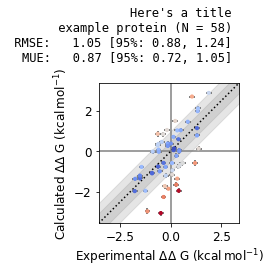

In [3]:
plotting.plot_DDGs(fe.graph,target_name='example protein', title="Here's a title")

The above is the plot of relative simulations that have been run, however the direction of the simulation is run in is arbitrary, and any data point could equally be plotted in the opposite quadrant. Note that the RMSE and MUE are unchanged. RMSE and MUE are left off these plots as they would change as theese datapoints are arbitrarily changed - hence they are not useful for assessment.

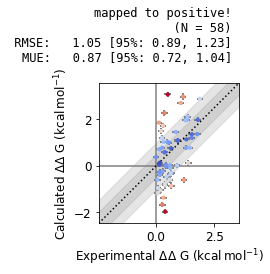

In [4]:
plotting.plot_DDGs(fe.graph,map_positive=True,title='mapped to positive!')

Because the direction of relative free energy calculations is arbitrary, we could equally just plot each data point twice, using `symmetrise`. Again, the statistics don't change, but the number of datapoints doubles.

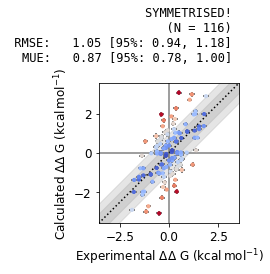

In [5]:
plotting.plot_DDGs(fe.graph,symmetrise=True,title='SYMMETRISED!')

Now lets look at what these relative free energies look like as absolute free energies. This requires there to be enough relative free energy results such that the graph is weakly connected. The relative free energy calculations are turned into absolute values under-the-hood using a maximum likelihood estimator (MLE).

Note that now, R2 and rho are also provided.

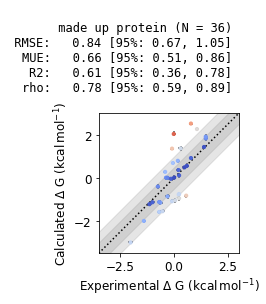

In [6]:
plotting.plot_DGs(fe.graph,method_name='softwarename',target_name='made up protein')

There are also different aesthetic details that can be changed in the plots

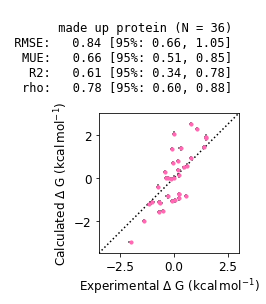

In [7]:
plotting.plot_DGs(fe.graph,method_name='softwarename',target_name='made up protein',
                  color='hotpink',guidelines=False)

In [8]:
def bootstrap_statistic(y_true, y_pred, dy_true=None, dy_pred=None, ci=0.95, statistic='RMSE', nbootstrap = 1000, plot_type='dG'):
    import sklearn.metrics
    import scipy
    """Compute mean and confidence intervals of specified statistic.

    Parameters
    ----------
    y_true : ndarray with shape (N,)
        True values
    y_pred : ndarray with shape (N,)
        Predicted values
    dy_true : ndarray with shape (N,) or None
        Errors of true values. If None, the values are assumed to have no errors
    dy_pred : ndarray with shape (N,) or None
        Errors of predicted values. If None, the values are assumed to have no errors
    ci : float, optional, default=0.95
        Interval for CI
    statistic : str
        Statistic, one of ['RMSE', 'MUE', 'R2', 'rho','KTAU','RAE']
    nbootstrap : int, optional, default=1000
        Number of bootstrap samples
    plot_type : str, optional, default='dG'
        'dG' or 'ddG'

    Returns
    -------
    rmse_stats : dict of floeat
        'mean' : mean RMSE
        'stderr' : standard error
        'low' : low end of CI
        'high' : high end of CI
    """

    def compute_statistic(y_true_sample, y_pred_sample, statistic):
        """Compute requested statistic.

        Parameters
        ----------
        y_true : ndarray with shape (N,)
            True values
        y_pred : ndarray with shape (N,)
            Predicted values
        statistic : str
            Statistic, one of ['RMSE', 'MUE', 'R2', 'rho','RAE','KTAU']

        """

        def calc_RAE(y_true_sample, y_pred_sample):
            MAE = sklearn.metrics.mean_absolute_error(y_true_sample, y_pred_sample)
            mean = np.mean(y_true_sample)
            MAD = np.sum([np.abs(mean-i) for i in y_true_sample]) / float(len(y_true_sample))
            return MAE / MAD

        def calc_RRMSE(y_true_sample, y_pred_sample):
            rmse = np.sqrt(sklearn.metrics.mean_squared_error(y_true_sample, y_pred_sample))
            mean_exp = np.mean(y_true_sample)
            mds = np.sum([(mean_exp - i) ** 2 for i in y_true_sample]) / float(len(y_true_sample))
            rrmse = np.sqrt(rmse ** 2 / mds)
            return rrmse

        if statistic == 'RMSE':
            return np.sqrt(sklearn.metrics.mean_squared_error(y_true_sample, y_pred_sample))
        elif statistic == 'MUE':
            return sklearn.metrics.mean_absolute_error(y_true_sample, y_pred_sample)
        elif statistic == 'R2':
            slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(y_true_sample, y_pred_sample)
            return r_value**2
        elif statistic == 'rho':
            return scipy.stats.pearsonr(y_true_sample, y_pred_sample)[0]
        elif statistic == 'RAE':
            return calc_RAE(y_true_sample, y_pred_sample)
        elif statistic == 'KTAU':
            return scipy.stats.kendalltau(y_true_sample, y_pred_sample)[0]
        else:
            raise Exception("unknown statistic '{}'".format(statistic))

    def unique_differences(x):
        """Compute all unique differences"""
        N = len(x)
        return np.array([(x[i] - x[j]) for i in range(N) for j in range(N) if (i != j)])

    if dy_true is None:
        dy_true = np.zeros_like(y_true)
    if dy_pred is None:
        dy_pred = np.zeros_like(y_pred)
    assert len(y_true) == len(y_pred)
    assert len(y_true) == len(dy_true)
    assert len(y_true) == len(dy_pred)
    sample_size = len(y_true)
    s_n = np.zeros([nbootstrap], np.float64) # s_n[n] is the statistic computed for bootstrap sample n
    for replicate in range(nbootstrap):
        y_true_sample = np.zeros_like(y_true)
        y_pred_sample = np.zeros_like(y_pred)
        for i,j in enumerate(np.random.choice(np.arange(sample_size), size=[sample_size], replace=True)):
            y_true_sample[i] = np.random.normal(loc=y_true[j], scale=np.fabs(dy_true[j]), size=1)
            y_pred_sample[i] = np.random.normal(loc=y_pred[j], scale=np.fabs(dy_pred[j]), size=1)
        s_n[replicate] = compute_statistic(y_true_sample, y_pred_sample, statistic)

    rmse_stats = dict()
    rmse_stats['mle'] = compute_statistic(y_true, y_pred, statistic)
    rmse_stats['stderr'] = np.std(s_n)
    rmse_stats['mean'] = np.mean(s_n)
    # TODO: Is there a canned method to do this?
    s_n = np.sort(s_n)
    low_frac = (1.0-ci)/2.0
    high_frac = 1.0 - low_frac
    rmse_stats['low'] = s_n[int(np.floor(nbootstrap*low_frac))]
    rmse_stats['high'] = s_n[int(np.ceil(nbootstrap*high_frac))]

    return s_n, rmse_stats

In [9]:
x = [x[2]['exp_DDG'] for x in fe.graph.edges(data=True)]
y = [x[2]['calc_DDG'] for x in fe.graph.edges(data=True)]

In [10]:
s_n, stat = bootstrap_statistic(x,y)

(array([ 18.,  43., 126., 212., 219., 203., 115.,  49.,   9.,   6.]),
 array([0.81299998, 0.86539688, 0.91779379, 0.9701907 , 1.0225876 ,
        1.07498451, 1.12738141, 1.17977832, 1.23217523, 1.28457213,
        1.33696904]),
 <BarContainer object of 10 artists>)

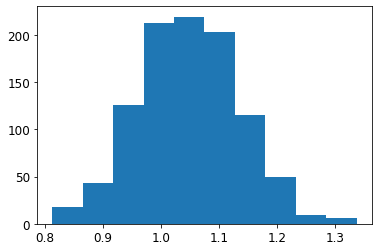

In [11]:
fig, ax = plt.subplots()

ax.hist(s_n)

In [12]:
print(stat)

{'mle': 1.0530022759251039, 'stderr': 0.08647859961972391, 'mean': 1.048086277417685, 'low': 0.8714187797237173, 'high': 1.224573113515411}


In [13]:
print(max(s_n))

1.336969037373922
